# Solution 2

```{hint} 
<a href='https://dust.ltpy.adamplatform.eu/hub/user-redirect/lab/tree/03_practical_case_study/solutions/02_exercise_solution.ipynb' target='_blank'>Execute the notebook on the training platform >></a>
```

## About

> Let us have a closer look at the forecast data from both models for one observation station in Tenerife (Canary Islands). Let us plot the time-series of the CAMS and MONARCH forecasts together in one plot.


## Tasks

**1. Download and animate the CAMS global forecast for 21 Feb 2020**
  * Download the CAMS global atmospheric composition forecast for 21 February 2020, with the following specifications:
    > Variable on single levels: `Dust aerosol optical depth at 550 nm` <br>
    > Date (Start and end): `2020-02-21` <br>
    > Time: `12:00` <br>
    > Leadtime hour: every three hours from `0 to 90` <br>
    > Type: `Forecast` <br>
    > Restricted area: `N: 67, W: -30, E: 71, S: -3` <br>
    > Format: `Zipped netCDF` <br>
  * **Hint** 
    * [CAMS global atmospheric composition forecasts - Example notebook](./cams_global.ipynb)
    * <a href='https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts' target='_blank'>Data access</a>

**2. Get the coordinates of the AERONET station *Santa Cruz, Tenerife***
  * **Hint**
    * You can see an overview of all available AERONET Site Names <a href='https://aeronet.gsfc.nasa.gov/cgi-bin/draw_map_display_aod_v3?long1=-180&long2=180&lat1=-90&lat2=90&multiplier=2&what_map=4&nachal=1&formatter=0&level=3&place_code=10&place_limit=0' target='_blank'>here</a>

**3. Select the time-series for CAMS global atmospheric composition forecasts for Santa Cruz, Tenerife**
  * **Hint**
    * With the xarray function `sel()` and keyword argument `method='nearest'` you can select data based on coordinate information
    * We also recommend you to transform your xarray.DataArray into a pandas.DataFrame with the function `to_dataframe()` and save it as `csv` with the function `to_csv()`

**4. Load the MONARCH dust forecasts and select time-series for Santa Cruz, Tenerife**
  * **Hint**
    * With the xarray function `sel()` and keyword argument `method='nearest'` you can select data based on coordinate information
    * We also recommend you to transform your xarray.DataArray into a pandas.DataFrame with the function `to_dataframe()` and save it as `csv` with the function `to_csv()`

**5. Visualize both time-series of CAMS and MONARCH forecasts together in one plot**

<hr>

**Load required libraries**

In [1]:
import xarray as xr
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
from matplotlib.axes import Axes

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

**Load helper functions**

In [2]:
%run ../../functions.ipynb

<hr>

### 1. Download and animate the CAMS global forecast for 21 Feb 2020 

First, we have to download the CAMS global atmospheric composition forecast data from the [Copernicus Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=form) with the following specifications:
* Variable on single levels: `Dust aerosol optical depth at 550 nm`
* Date (Start and end): `2020-02-21`
* Time: `12:00`
* Leadtime hour: every three hours from `0 to 90`
* Type: `Forecast`
* Restricted area: `N: 67, W: -30, E: 71, S: -3`
* Format: `Zipped netCDF`

See the `CDSAPI` request below.

In [3]:
URL = 'https://ads.atmosphere.copernicus.eu/api/v2'
KEY = '######################'

In [ ]:
import cdsapi

c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'variable': 'dust_aerosol_optical_depth_550nm',
        'date': '2020-02-21/2020-02-21',
        'time': '12:00',
        'leadtime_hour': [
            '0', '12', '15',
            '18', '21', '24',
            '27', '3', '30',
            '33', '36', '39',
            '42', '45', '48',
            '51', '54', '57',
            '6', '60', '63',
            '66', '69', '72',
            '75', '78', '81',
            '84', '87', '9',
            '90',
        ],
        'type': 'forecast',
        'area': [
            67, -30, -3,
            71,
        ],
        'format': 'netcdf_zip',
    },
    '../../eodata/case_study/cams/20210221_dustAOD.zip')

The first step is to unzip file from the zipped archive downloaded.

In [ ]:
import zipfile
with zipfile.ZipFile('../../eodata/case_study/cams/20200221_dustAOD.zip', 'r') as zip_ref:
    zip_ref.extractall('../../')

<br>

Then, we can open the netCDF file with the xarray function `open_dataset()`. We see that the data has three dimensions (`latitude`, `longitude`, `time`) and one data variable:
* `duaod550`: Dust Aerosol Optical Depth at 550nm

In [5]:
file = xr.open_dataset('../../eodata/case_study/cams/data.nc')
file

<xarray.Dataset>
Dimensions:    (longitude: 253, latitude: 176, time: 31)
Coordinates:
  * longitude  (longitude) float32 -30.0 -29.6 -29.2 -28.8 ... 70.0 70.4 70.8
  * latitude   (latitude) float32 67.0 66.6 66.2 65.8 ... -1.8 -2.2 -2.6 -3.0
  * time       (time) datetime64[ns] 2020-02-21T12:00:00 ... 2020-02-25T06:00:00
Data variables:
    duaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-02 14:50:00 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

<br>

Let us now store the data variable `Dust Aerosol Optical Depth (AOD) at 550nm` as `xarray.DataArray` with the name `du_aod`.

In [6]:
du_aod = file.duaod550
du_aod

<xarray.DataArray 'duaod550' (time: 31, latitude: 176, longitude: 253)>
[1380368 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -30.0 -29.6 -29.2 -28.8 ... 70.0 70.4 70.8
  * latitude   (latitude) float32 67.0 66.6 66.2 65.8 ... -1.8 -2.2 -2.6 -3.0
  * time       (time) datetime64[ns] 2020-02-21T12:00:00 ... 2020-02-25T06:00:00
Attributes:
    units:      ~
    long_name:  Dust Aerosol Optical Depth at 550nm

Above, you see that the variable `du_aod` has two attributes, `units` and `long_name`. Let us define variables for those attributes. The variables can be used for visualizing the data.

In [7]:
long_name = du_aod.long_name
units = du_aod.units

Let us do the same for the coordinates `longitude` and `latitude`.

In [8]:
latitude = du_aod.latitude
longitude = du_aod.longitude

<br>

**Visualize one forecast step of *Dust Aerosol Optical Depth at 550nm***

The next step is to visualize the dataset. You can use the function `visualize_pcolormesh`, which makes use of matploblib's function `pcolormesh` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Dust Aerosol Optical Depth at 550nm 2020-02-21T12:00:00.000000000'}>)

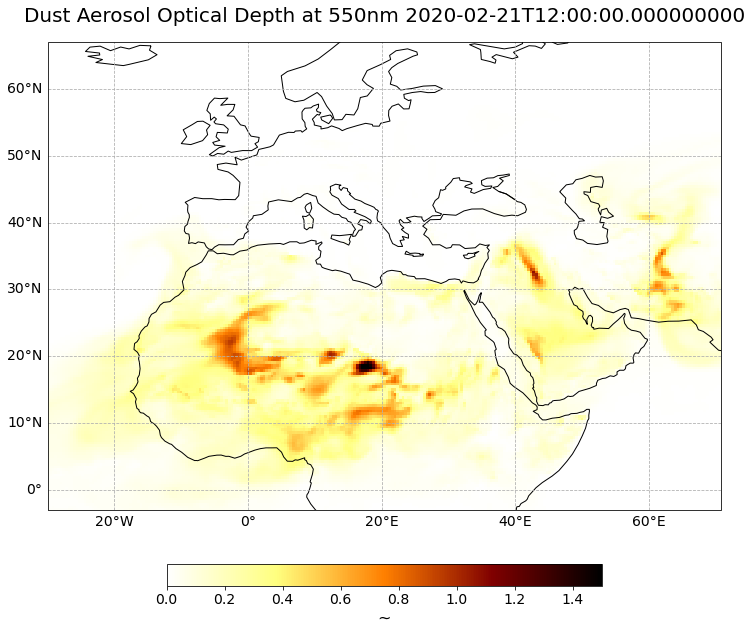

In [9]:
visualize_pcolormesh(data_array=du_aod[0,:,:],
                     longitude=longitude,
                     latitude=latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='afmhot_r',
                     unit=units,
                     long_name=long_name + ' ' + str(du_aod[0,:,:].time.data),
                     vmin=0, 
                     vmax=1.5,
                     set_global=False,
                    lonmin=du_aod.longitude.min(),
                    lonmax=du_aod.longitude.max(),
                    latmin=du_aod.latitude.min(),
                    latmax=du_aod.latitude.max())

<br>

Now, we can also animate the forecast. The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [ ]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=du_aod[0,:,:],
                               longitude=du_aod.longitude, 
                               latitude=du_aod.latitude,
                               projection=ccrs.PlateCarree(), 
                               color_scale='afmhot_r', 
                               unit='-',
                               long_name=long_name + ' '+ str(du_aod.time[0].data),
                               vmin=0,
                               vmax=1, 
                                lonmin=du_aod.longitude.min(),
                                lonmax=du_aod.longitude.max(),
                                latmin=du_aod.latitude.min(),
                                latmax=du_aod.latitude.max(),
                               set_global=False)

frames = 30

def draw(i):
    img = plt.pcolormesh(du_aod.longitude, 
                         du_aod.latitude, 
                         du_aod[i,:,:], 
                         cmap='afmhot_r', 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=1,
                         shading='auto')
    
    ax.set_title(long_name + ' '+ str(du_aod.time[i].data), fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)

<br>

**Play the animation video as HTML5 video**

In [ ]:
HTML(ani.to_html5_video())

<br>

### 2. Select latitude / longitude values for Santa Cruz, Tenerife

You can see an overview of all available AERONET Site Names [here](https://aeronet.gsfc.nasa.gov/cgi-bin/draw_map_display_aod_v3?long1=-180&long2=180&lat1=-90&lat2=90&multiplier=2&what_map=4&nachal=1&formatter=0&level=3&place_code=10&place_limit=0). Let's look up the latitude and longitude information for the station `Santa_Cruz_Tenerife` and define the coordinate information as variables.

In [12]:
lat = 28.473
lon = -16.247

<br>

### 3. Select the time-series for CAMS global atmospheric composition forecasts for Santa Cruz, Tenerife

From the loaded xarray data array `du_aod`, we can now select the values for one specific point location. We can select coordinate information with the function `sel()`. We have to make sure to set the keyword argument `method='nearest'`. With this keyword argument, the closest grid location in the data array is used for the time-series retrieval.

In [13]:
cams_ts = du_aod.sel(longitude=lon, latitude=lat, method='nearest')
cams_ts

<xarray.DataArray 'duaod550' (time: 31)>
array([5.676746e-04, 5.676746e-04, 1.460314e-03, 2.421856e-03, 5.305767e-03,
       1.128006e-02, 8.077216e-02, 2.031391e-01, 3.358061e-01, 5.017774e-01,
       5.811578e-01, 7.555066e-01, 1.102213e+00, 1.210434e+00, 1.024824e+00,
       9.059588e-01, 7.769997e-01, 6.033378e-01, 5.451070e-01, 4.923698e-01,
       3.647155e-01, 2.810775e-01, 1.702471e-01, 2.191389e-01, 3.551019e-01,
       5.156484e-01, 6.221528e-01, 8.869376e-01, 1.008824e+00, 7.652575e-01,
       6.062905e-01], dtype=float32)
Coordinates:
    longitude  float32 -16.4
    latitude   float32 28.6
  * time       (time) datetime64[ns] 2020-02-21T12:00:00 ... 2020-02-25T06:00:00
Attributes:
    units:      ~
    long_name:  Dust Aerosol Optical Depth at 550nm

<br>

Time-series information is better to handle via the Python library [Pandas](https://pandas.pydata.org/). You can use the function `to_dataframe()` to convert a xarray.DataArray into a pandas.DataFrame.

In [14]:
cams_ts_df = cams_ts.to_dataframe()
cams_ts_df

longitude  latitude  duaod550
time                                              
2020-02-21 12:00:00      -16.4      28.6  0.000568
2020-02-21 15:00:00      -16.4      28.6  0.000568
2020-02-21 18:00:00      -16.4      28.6  0.001460
2020-02-21 21:00:00      -16.4      28.6  0.002422
2020-02-22 00:00:00      -16.4      28.6  0.005306
2020-02-22 03:00:00      -16.4      28.6  0.011280
2020-02-22 06:00:00      -16.4      28.6  0.080772
2020-02-22 09:00:00      -16.4      28.6  0.203139
2020-02-22 12:00:00      -16.4      28.6  0.335806
2020-02-22 15:00:00      -16.4      28.6  0.501777
2020-02-22 18:00:00      -16.4      28.6  0.581158
2020-02-22 21:00:00      -16.4      28.6  0.755507
2020-02-23 00:00:00      -16.4      28.6  1.102213
2020-02-23 03:00:00      -16.4      28.6  1.210434
2020-02-23 06:00:00      -16.4      28.6  1.024824
2020-02-23 09:00:00      -16.4      28.6  0.905959
2020-02-23 12:00:00      -16.4      28.6  0.777000
2020-02-23 15:00:00      -16.4      28.6  0.603338
2020-02-23 18:00:00      -16.4      28.6  0.545107
2020-02-23 21:00:00      -16.4      28.6  0.492370
2020-02-24 00:00:00      -16.4      28.6  0.364715
2020-02-24 03:00:00      -16.4      28.6  0.281078
2020-02-24 06:00:00      -16.4      28.6  0.170247
2020-02-24 09:00:00      -16.4      28.6  0.219139
2020-02-24 12:00:00      -16.4      28.6  0.355102
2020-02-24 15:00:00      -16.4      28.6  0.515648
2020-02-24 18:00:00      -16.4      28.6  0.622153
2020-02-24 21:00:00      -16.4      28.6  0.886938
2020-02-25 00:00:00      -16.4      28.6  1.008824
2020-02-25 03:00:00      -16.4      28.6  0.765257
2020-02-25 06:00:00      -16.4      28.6  0.606290

<br>

The last step is now to safe the pandas dataframe as csv file. This allows us to easily load the time-series again later. You can use the function `to_csv()` to save a pandas.DataFrame as csv.

In [ ]:
cams_ts_df.to_csv("../../cams_ts.csv", index_label='time')

<br>

### 4. Load MONARCH dust forecasts and select time-series

The first step is to load a `MONARCH` forecast file. The data is disseminated in the `netCDF` format on a daily basis, with the forecast initialisation at 12:00 UTC. Load the `MONARCH` dust forecast of 21 February 2020. You can use the function `open_dataset()` from the xarray Python library.

Once loaded, you see that the data has three dimensions: `lat`, `lon` and `time`; and offers two data variables `od550_dust` and `sconc_dust`.

In [15]:
filepath = '../../eodata/case_study/sds_was/2020022112_3H_NMMB-BSC.nc'
file = xr.open_dataset(filepath)
file

<xarray.Dataset>
Dimensions:     (lon: 307, lat: 211, time: 25)
Coordinates:
  * lon         (lon) float64 -31.0 -30.67 -30.33 -30.0 ... 70.33 70.67 71.0
  * lat         (lat) float64 -3.0 -2.667 -2.333 -2.0 ... 66.0 66.33 66.67 67.0
  * time        (time) datetime64[ns] 2020-02-21T12:00:00 ... 2020-02-24T12:0...
Data variables:
    od550_dust  (time, lat, lon) float32 ...
    sconc_dust  (time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.5.4 (http://c...
    Conventions:               CF-1.2
    history:                   Fri Feb 21 23:50:54 2020: cdo remapbil,regular...
    _FillValue:                -32767.0
    missing_value:             -32767.0
    title:                     Regional Reanalysis 0.5x0.5 deg NMMB-BSC-Dust ...
    History:                   Fri Feb 21 22:12:45 2020: ncrcat -F -O pout_re...
    Grid_type:                 B-grid: vectors interpolated to scalar positions
    Map_Proj:                  Rotated latitude longitude
    NCO:                       4.0.8
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.5.4 (http://c...

<br>

Let us then retrieve the data variable `od550_dust`, which is the dust optical depth at 550 nm.

In [16]:
od_dust_sdswas = file['od550_dust']
od_dust_sdswas

<xarray.DataArray 'od550_dust' (time: 25, lat: 211, lon: 307)>
[1619425 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -31.0 -30.67 -30.33 -30.0 ... 70.0 70.33 70.67 71.0
  * lat      (lat) float64 -3.0 -2.667 -2.333 -2.0 ... 66.0 66.33 66.67 67.0
  * time     (time) datetime64[ns] 2020-02-21T12:00:00 ... 2020-02-24T12:00:00
Attributes:
    long_name:  dust optical depth at 550 nm
    units:       
    title:      dust optical depth at 550 nm

<br>

Now, we can also select the time-series for the location *Santa Cruz, Tenerife* from the WMO SDS-WAS forecast data. We again use the function `sel()` together with the keyword argument `method='nearest'` to select the forecast time-series of the closest grid point.

In [17]:
sds_was_ts = od_dust_sdswas.sel(lon=lon, lat=lat, method='nearest')
sds_was_ts

<xarray.DataArray 'od550_dust' (time: 25)>
array([5.792578e-05, 1.870866e-05, 2.691938e-05, 2.069314e-04, 8.895606e-04,
       1.751463e-03, 9.110953e-03, 5.093248e-02, 2.034178e-01, 3.637045e-01,
       4.338350e-01, 1.095499e+00, 2.165373e+00, 2.052835e+00, 8.611195e-01,
       7.533937e-01, 4.669310e-01, 3.542736e-01, 3.206273e-01, 2.312253e-01,
       1.795649e-01, 2.214468e-01, 4.775718e-01, 7.005243e-01, 1.151538e+00],
      dtype=float32)
Coordinates:
    lon      float64 -16.33
    lat      float64 28.33
  * time     (time) datetime64[ns] 2020-02-21T12:00:00 ... 2020-02-24T12:00:00
Attributes:
    long_name:  dust optical depth at 550 nm
    units:       
    title:      dust optical depth at 550 nm

<br>

And now, we also want to save the MONARCH forecast time-series as pandas.DataFrame in a csv file. You can combine both functions (`to_dataframe()` and `to_csv`) in one line of code.

In [ ]:
sds_was_ts.to_dataframe().to_csv("../../sdswas_ts.csv", index_label='time')

<br>

### 5. Visualize time-series of CAMS and MONARCH forecasts together in one plot

The last step is to visualize both pandas.DataFrame objects (`sds_was_ts` and `cams_ts_df`) as line plots. You can use the generic `plot()` function from matplotlib to visualize a simple line plot.

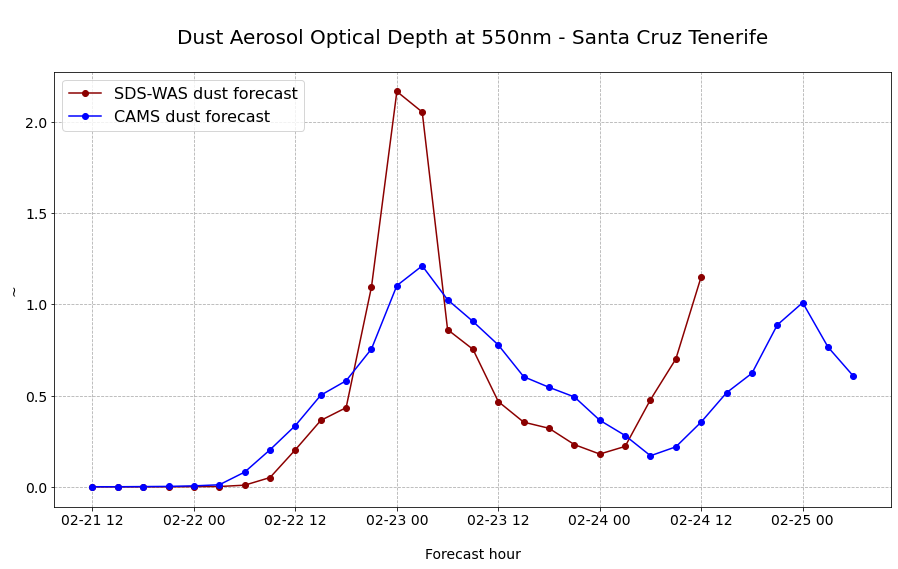

In [18]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Define the plotting function
ax.plot(sds_was_ts.time, sds_was_ts, 'o-', color='darkred',  label='SDS-WAS dust forecast')
ax.plot(cams_ts_df.index, cams_ts, 'o-', color='blue', label='CAMS dust forecast')

# Customize the title and axes lables
ax.set_title('\n'+cams_ts.long_name+' - Santa Cruz Tenerife\n', fontsize=20)
ax.set_ylabel(cams_ts.units, fontsize=14)
ax.set_xlabel('\nForecast hour', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

plt.legend(fontsize=16, loc=2)